
# Практическая работа: Статистическая обработка социально‑экономических показателей субъектов РФ

Этот ноутбук – шаблон для выполнения работы в Python (pandas + statsmodels + matplotlib).  
Заполните путь к Excel‑файлу с данными (`!ПР5.Ранг кредитоспособности.xlsx`) и запустите все ячейки сверху вниз.

## Состав данных (сокращения столбцов)
- `RANG` – ранг кредитоспособности населения (целевой показатель)
- `Chisl` – численность населения, тыс. чел.
- `IBR` – индекс бюджетных расходов
- `Doh_reg` – собственные доходы регионального бюджета, млн руб.
- `Doh_budz` – доходы бюджета региона, млн руб.
- `Rash_budz` – расходы бюджета региона, млн руб.
- `Deph_Proph` – дефицит(–)/профицит(+) бюджета региона, млн руб.
- `Fin_pom` – финпомощь, направляемая в бюджеты других уровней, млн руб.
- `Kred` – объём выделяемых кредитов (бюджетных ссуд), млн руб.

## Что делает ноутбук
1. Загружает и приводит данные к нужным именам столбцов.
2. Считает **описательную статистику** по числовым признакам (кроме целевого `RANG`, если требуется).
3. Строит **7+ графиков** (гистограммы, диаграммы размаха, scatter‑пары и корреляции).
4. Строит **две регрессионные модели (OLS)**:
   - Модель A: влияние факторов на `RANG` (в т.ч. `Chisl`).
   - Модель B: влияние факторов на `Kred` (в т.ч. `Rash_budz`).
5. Проверяет базовые предпосылки (VIF, нормальность остатков, гетероскедастичность).
6. Выводит итоги и рекомендации.


In [1]:

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List

# Статистика и регрессия
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Графики будут отображаться в ноутбуке
%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')


In [8]:

# === УКАЖИТЕ ПУТЬ К ФАЙЛУ EXCEL ===
# Например: data_path = Path('/mnt/data/!ПР5.Ранг кредитоспособности.xlsx')
data_path = Path('raw5.xls')  # <-- при необходимости измените

# Если в книге несколько листов, укажите имя/индекс нужного
sheet_name = "табл"  # или 'Лист1'

df_raw = pd.read_excel(data_path, sheet_name=sheet_name)
print('Форма исходных данных:', df_raw.shape)
df_raw.head()


Форма исходных данных: (88, 10)


,с,Chisl,IBR,Doh_reg,Doh_budz,Rash_budz,Deph_Proph,Fin_pom,Kred,RANG
0,1,1498,0.800,"7,340.400","12,216.900","12,542.000",-325.100,"2,025.100",255.800,40
1,2,1410,0.824,"4,442.900","10,323.700","10,504.300",-180.600,"2,078.600",101.900,59
2,3,1574,0.786,"6,213.600","13,504.200","13,455.400",48.800,"3,364.000",233.500,54
3,4,2415,0.772,"8,319.900","16,159.200","17,459.300","1,300.100","2,777.100",41.600,27
4,5,1119,0.840,"3,362.100","10,373.700","10,423.500",-49.800,"2,475.700","38,444.000",63


In [9]:

# Приведём названия столбцов к ожидаемым сокращениям, если это требуется.
# Попробуем сопоставить возможные варианты.

expected = {
    'RANG': ['RANG', 'Ранг', 'Ранг кредитоспособности', 'Rank', 'Кредитоспособность'],
    'Chisl': ['Chisl', 'Численность', 'Численность населения', 'Население'],
    'IBR': ['IBR', 'Индекс бюджетных расходов', 'Ибр'],
    'Doh_reg': ['Doh_reg', 'Собственные доходы', 'Собственные доходы бюджета'],
    'Doh_budz': ['Doh_budz', 'Доходы бюджета', 'Доходы бюджета региона'],
    'Rash_budz': ['Rash_budz', 'Расходы бюджета', 'Расходы бюджета региона'],
    'Deph_Proph': ['Deph_Proph', 'Дефицит/Профицит', 'Дефицит', 'Профицит'],
    'Fin_pom': ['Fin_pom', 'Финансовая помощь', 'Финпомощь', 'Фин помощь'],
    'Kred': ['Kred', 'Кредиты', 'Объем кредитов', 'Бюджетные ссуды']
}

rename_map = {}
cols = list(df_raw.columns)

for target, variants in expected.items():
    for v in variants:
        for c in cols:
            if str(c).strip().lower() == str(v).strip().lower():
                rename_map[c] = target
                break

df = df_raw.rename(columns=rename_map).copy()

# Если столбца нет после переименования – предупредим
missing = [k for k in expected.keys() if k not in df.columns]
if missing:
    print('⚠️ Не найдены столбцы:', missing)

df.head()


,с,Chisl,IBR,Doh_reg,Doh_budz,Rash_budz,Deph_Proph,Fin_pom,Kred,RANG
0,1,1498,0.800,"7,340.400","12,216.900","12,542.000",-325.100,"2,025.100",255.800,40
1,2,1410,0.824,"4,442.900","10,323.700","10,504.300",-180.600,"2,078.600",101.900,59
2,3,1574,0.786,"6,213.600","13,504.200","13,455.400",48.800,"3,364.000",233.500,54
3,4,2415,0.772,"8,319.900","16,159.200","17,459.300","1,300.100","2,777.100",41.600,27
4,5,1119,0.840,"3,362.100","10,373.700","10,423.500",-49.800,"2,475.700","38,444.000",63


In [10]:

# Оставим числовые столбцы (регион/название могут быть нечисловыми)
numeric_df = df.select_dtypes(include=[np.number]).copy()

# Иногда ранг целевой, поэтому можем убрать его из блока описательной статистики (если это требование)
features_for_desc = [c for c in numeric_df.columns]  # полное множество
if 'RANG' in features_for_desc:
    features_for_desc.remove('RANG')

desc = numeric_df[features_for_desc].describe().T
desc


,count,mean,std,min,25%,50%,75%,max
с,88.000,44.500,25.547,1.000,22.750,44.500,66.250,88.000
Chisl,88.000,"1,655.034","1,492.716",18.000,740.250,"1,248.000","2,253.000","8,539.000"
IBR,88.000,1.474,1.393,0.597,0.821,0.921,1.479,7.790
Doh_reg,88.000,"13,620.219","30,821.931",234.300,"3,136.775","6,107.500","13,579.375","273,169.400"
Doh_budz,88.000,"21,421.475","33,380.969","1,403.500","7,850.575","12,752.000","23,683.125","281,781.400"
Rash_budz,88.000,"20,689.472","33,936.942","1,378.900","8,125.225","12,921.850","23,384.275","304,173.700"
Deph_Proph,88.000,-329.659,"2,547.338","-22,392.200",-358.350,-142.000,59.725,"5,229.800"
Fin_pom,88.000,"3,214.088","4,093.674",0.100,"1,258.700","2,103.200","3,328.475","33,957.300"
Kred,88.000,917.399,"4,193.376",0.000,30.125,122.600,397.850,"38,444.000"


Графиков построено: 15


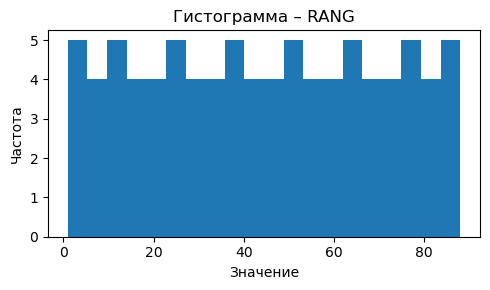

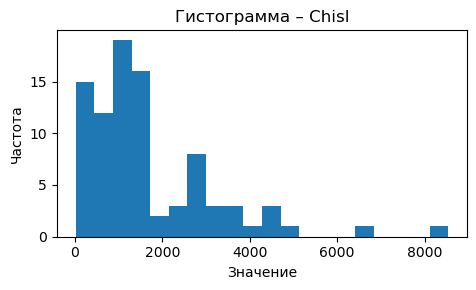

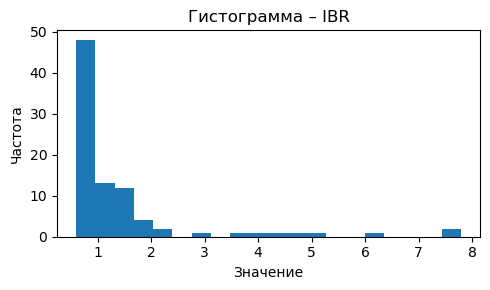

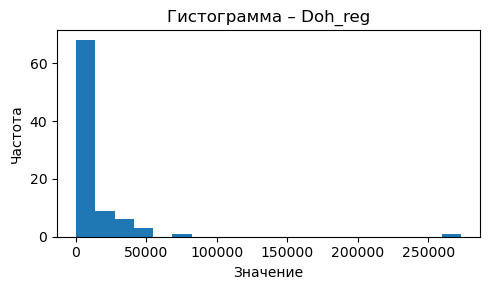

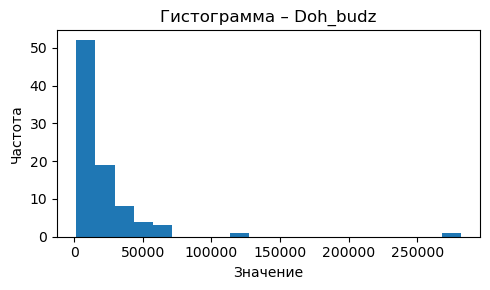

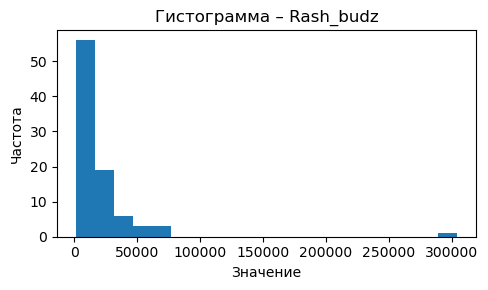

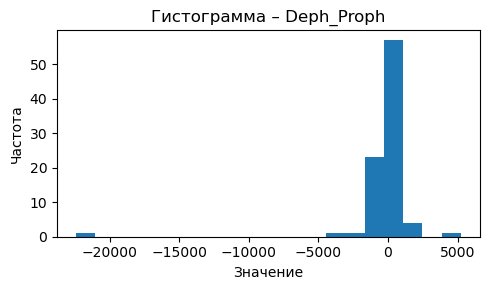

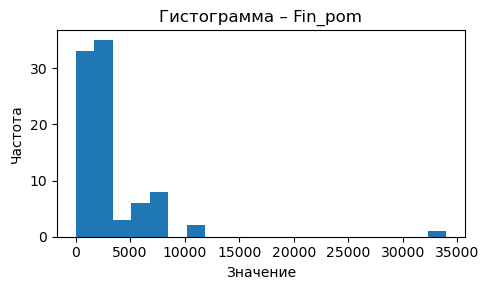

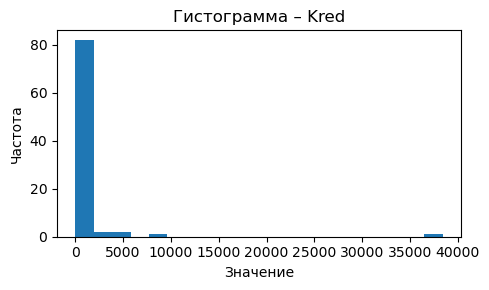

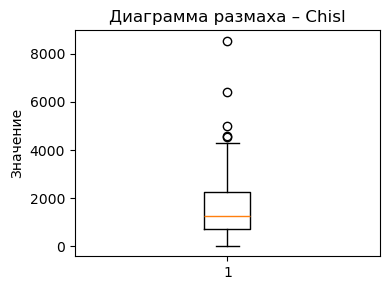

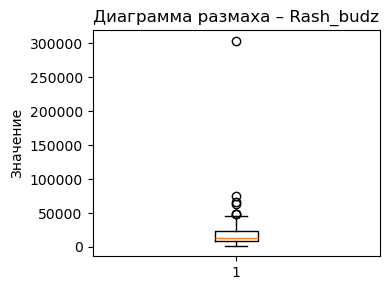

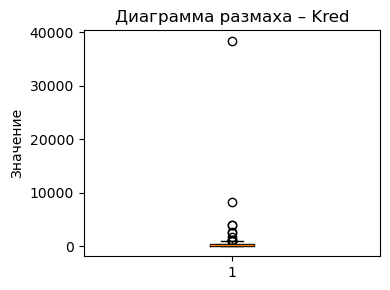

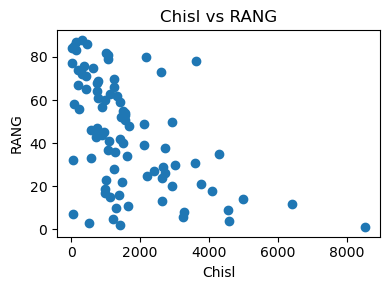

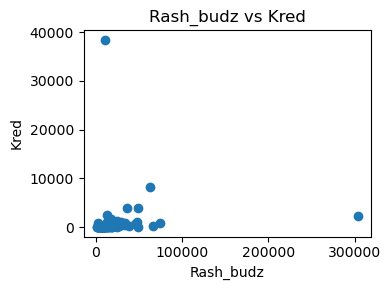

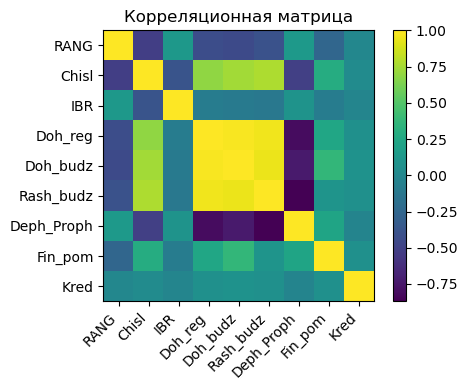

In [17]:

# --- Визуализации (не менее 7) ---
# 1) Гистограммы для основных показателей
figures = []

def safe_hist(series, title):
    fig = plt.figure(figsize=(5, 3))
    plt.hist(series.dropna(), bins=20)
    plt.title(title)
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.tight_layout()
    figures.append(fig)

for col in ['RANG','Chisl','IBR','Doh_reg','Doh_budz','Rash_budz','Deph_Proph','Fin_pom','Kred']:
    if col in numeric_df.columns:
        safe_hist(numeric_df[col], f'Гистограмма – {col}')

# 2) Диаграммы размаха (boxplot) для распределений
def safe_box(series, title):
    fig = plt.figure(figsize=(4, 3))
    plt.boxplot(series.dropna(), vert=True)
    plt.title(title)
    plt.ylabel('Значение')
    plt.tight_layout()
    figures.append(fig)

for col in ['Chisl','Rash_budz','Kred']:
    if col in numeric_df.columns:
        safe_box(numeric_df[col], f'Диаграмма размаха – {col}')

# 3) Scatter: Chisl vs RANG
if set(['Chisl','RANG']).issubset(numeric_df.columns):
    fig = plt.figure(figsize=(4, 3))
    plt.scatter(numeric_df['Chisl'], numeric_df['RANG'])
    plt.xlabel('Chisl')
    plt.ylabel('RANG')
    plt.title('Chisl vs RANG')
    plt.tight_layout()
    figures.append(fig)

# 4) Scatter: Rash_budz vs Kred
if set(['Rash_budz','Kred']).issubset(numeric_df.columns):
    fig = plt.figure(figsize=(4, 3))
    plt.scatter(numeric_df['Rash_budz'], numeric_df['Kred'])
    plt.xlabel('Rash_budz')
    plt.ylabel('Kred')
    plt.title('Rash_budz vs Kred')
    plt.tight_layout()
    figures.append(fig)

# 5) Корреляционная матрица (тепловая карта)
corr_cols = [c for c in ['RANG','Chisl','IBR','Doh_reg','Doh_budz','Rash_budz','Deph_Proph','Fin_pom','Kred'] if c in numeric_df.columns]
corr = numeric_df[corr_cols].corr()
fig = plt.figure(figsize=(5, 4))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar()
plt.title('Корреляционная матрица')
plt.tight_layout()
figures.append(fig)

print(f'Графиков построено: {len(figures)}')
plt.show()


In [12]:

def compute_vif(frame, cols: List[str]):
    X = frame[cols].dropna().copy()
    X = sm.add_constant(X, has_constant='add')
    vif = []
    for i, name in enumerate(X.columns):
        if name == 'const':
            continue
        try:
            v = variance_inflation_factor(X.values, i)
        except Exception as e:
            v = np.nan
        vif.append({'feature': name, 'VIF': v})
    return pd.DataFrame(vif).sort_values('VIF', ascending=False)



In [13]:

# --- Регрессия A: RANG ---
target_A = 'RANG'
candidates_A = [c for c in ['Chisl','IBR','Doh_reg','Doh_budz','Rash_budz','Deph_Proph','Fin_pom'] if c in numeric_df.columns]

available = [c for c in candidates_A if c in numeric_df.columns]
print('Факторы для модели A:', available)

reg_A_df = numeric_df[[target_A] + available].dropna()
X_A = sm.add_constant(reg_A_df[available], has_constant='add')
y_A = reg_A_df[target_A]

model_A = sm.OLS(y_A, X_A).fit()
print(model_A.summary())

# VIF для A
vif_A = compute_vif(reg_A_df, available)
vif_A


Факторы для модели A: ['Chisl', 'IBR', 'Doh_reg', 'Doh_budz', 'Rash_budz', 'Deph_Proph', 'Fin_pom']
                            OLS Regression Results                            
Dep. Variable:                   RANG   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     9.602
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           1.31e-08
Time:                        00:07:43   Log-Likelihood:                -382.70
No. Observations:                  88   AIC:                             781.4
Df Residuals:                      80   BIC:                             801.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

,feature,VIF
3,Doh_budz,296.064
2,Doh_reg,174.031
4,Rash_budz,70.421
6,Fin_pom,9.912
5,Deph_Proph,9.170
0,Chisl,6.006
1,IBR,1.395


In [14]:

# --- Регрессия B: Kred ---
target_B = 'Kred'
candidates_B = [c for c in ['Rash_budz','Chisl','IBR','Doh_reg','Doh_budz','Deph_Proph','Fin_pom','RANG'] if c in numeric_df.columns]

available_B = [c for c in candidates_B if c in numeric_df.columns]
print('Факторы для модели B:', available_B)

reg_B_df = numeric_df[[target_B] + available_B].dropna()
X_B = sm.add_constant(reg_B_df[available_B], has_constant='add')
y_B = reg_B_df[target_B]

model_B = sm.OLS(y_B, X_B).fit()
print(model_B.summary())

# VIF для B
vif_B = compute_vif(reg_B_df, available_B)
vif_B


Факторы для модели B: ['Rash_budz', 'Chisl', 'IBR', 'Doh_reg', 'Doh_budz', 'Deph_Proph', 'Fin_pom', 'RANG']
                            OLS Regression Results                            
Dep. Variable:                   Kred   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3632
Date:                Wed, 08 Oct 2025   Prob (F-statistic):              0.937
Time:                        00:07:47   Log-Likelihood:                -856.81
No. Observations:                  88   AIC:                             1732.
Df Residuals:                      79   BIC:                             1754.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

,feature,VIF
4,Doh_budz,307.380
3,Doh_reg,192.403
0,Rash_budz,70.450
5,Deph_Proph,10.434
6,Fin_pom,9.915
1,Chisl,6.967
7,RANG,1.840
2,IBR,1.403


In [15]:

# --- Диагностика остатков (нормальность и гетероскедастичность) ---
def residual_diagnostics(model, title_prefix='Model'):
    resid = model.resid
    fig = plt.figure(figsize=(5, 3))
    plt.hist(resid, bins=20)
    plt.title(f'{title_prefix}: распределение остатков')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.tight_layout()

    # Тест Жарке–Бера (нормальность)
    jb_stat, jb_pvalue, _, _ = sms.jarque_bera(resid)

    # Тест Бройша–Пагана (гетероскедастичность)
    lm, lm_pvalue, f_stat, f_pvalue = sms.het_breuschpagan(resid, model.model.exog)

    return {
        'jarque_bera_stat': jb_stat,
        'jarque_bera_pvalue': jb_pvalue,
        'bp_lm_stat': lm,
        'bp_lm_pvalue': lm_pvalue,
        'bp_f_stat': f_stat,
        'bp_f_pvalue': f_pvalue
    }

diag_A = residual_diagnostics(model_A, 'Модель A (RANG)')
diag_B = residual_diagnostics(model_B, 'Модель B (Kred)')

print('Диагностика модели A:', diag_A)
print('Диагностика модели B:', diag_B)


Диагностика модели A: {'jarque_bera_stat': 1.0337243923379962, 'jarque_bera_pvalue': 0.5963889666558714, 'bp_lm_stat': 9.103283155665302, 'bp_lm_pvalue': 0.24532558256875356, 'bp_f_stat': 1.3186546403990524, 'bp_f_pvalue': 0.2523831363075769}
Диагностика модели B: {'jarque_bera_stat': 21896.654313199437, 'jarque_bera_pvalue': 0.0, 'bp_lm_stat': 1.0517899725059756, 'bp_lm_pvalue': 0.997899510537369, 'bp_f_stat': 0.11945531685140127, 'bp_f_pvalue': 0.9983378622270127}



## Выводы и интерпретация (шаблон – допишите свои наблюдения)

- **Описательная статистика**: укажите медианы/средние, разбросы, выбросы; что удивило.
- **Корреляции**: какие пары факторов наиболее связаны; возможная мультиколлинеарность.
- **Модель A (цель – `RANG`)**: значимые коэффициенты, знак влияния `Chisl`; $R^2$, качество модели.
- **Модель B (цель – `Kred`)**: значимые коэффициенты, знак влияния `Rash_budz`; $R^2$, качество.
- **Диагностика остатков**: выполняются ли предпосылки; если нет – как улучшать (лог‑преобразования, робастные ошибки, отбор признаков).
- **Итог**: кратко сформулируйте ответы по заданию и практические рекомендации для региона/аналитика.
